## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Dependencies

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.2 MB/s 
     |████████████████████████████████| 163 kB 41.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.9 MB/s 


In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 64.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=4b2b308f1fbc408df6bf0964f6c74307e04d7bbf44eeece510da6e5470329e58
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishalnarnaware","key":"ec5ca920dc8759f90bc25c5074ea5aee"}'}

In [ ]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d naineshulke/factify-data 

100% 6.46G/6.47G [01:11<00:00, 123MB/s]
100% 6.47G/6.47G [01:11<00:00, 97.3MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/factify-data.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/FactifyData")
zip_ref.close()

In [ ]:
# !unzip factify-data.zip -d /content/drive/MyDrive/FactifyData

## Preprocess Data

In [ ]:
import pandas as pd
import pickle
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
])

df = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean.csv', index_col='Id')[['claim', 'claim_image', 'document', 'document_image', 'Category']]

category = {
    'Support_Multimodal': 0,
    'Support_Text': 1,
    'Insufficient_Multimodal': 2,
    'Insufficient_Text': 3,
    'Refute': 4
}

df['Label'] = df['Category'].map(category)

_, df = train_test_split(df, test_size=0.10, random_state=0, stratify=df[['Label']])

print(df.shape)

data, ids = {}, []
for n, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = '/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/train/'
    filename = path + 'claim/' + row['Category'] + '/' + str(n) + '.jpg'
    input_claim_image = Image.open(filename)
    claim_image = preprocess(input_claim_image)

    filename = path + 'document/' + row['Category'] + '/' + str(n) + '.jpg'
    input_document_image = Image.open(filename)
    document_image = preprocess(input_document_image)

    data[n] = (row['claim'], claim_image, row['document'], document_image, row['Label'])
    
    
with open('/content/drive/MyDrive/FactifyData/processed_train.pickle', 'wb') as file:
    pickle.dump(data, file)

(3500, 6)


100%|██████████| 3500/3500 [02:12<00:00, 26.49it/s]


In [ ]:
del data

In [ ]:
import pandas as pd
import pickle
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
])

df = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean.csv', index_col='Id')[['claim', 'claim_image', 'document', 'document_image', 'Category']]

category = {
    'Support_Multimodal': 0,
    'Support_Text': 1,
    'Insufficient_Multimodal': 2,
    'Insufficient_Text': 3,
    'Refute': 4
}

df['Label'] = df['Category'].map(category)

_, df = train_test_split(df, test_size=0.10, random_state=0, stratify=df[['Label']])

print(df.shape)

data, ids = {}, []
for n, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = '/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/val/'
    filename = path + 'claim/' + str(n) + '.jpg'
    input_claim_image = Image.open(filename)
    claim_image = preprocess(input_claim_image)

    filename = path + 'document/' + str(n) + '.jpg'
    input_document_image = Image.open(filename)
    document_image = preprocess(input_document_image)

    data[n] = (row['claim'], claim_image, row['document'], document_image, row['Label'])
    
    
with open('/content/drive/MyDrive/FactifyData/processed_val.pickle', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
del data

## Subset Dataset

In [ ]:
subset = 0.01   # 1% for rapid prototyping, 5% for checking, 10% for final training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

content = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean.csv')

category = {
    'Support_Multimodal': 0,
    'Support_Text': 1,
    'Insufficient_Multimodal': 2,
    'Insufficient_Text': 3,
    'Refute': 4
}

content['Label'] = content['Category'].map(category)
content = content.dropna(subset=['claim', 'document'])
_, content = train_test_split(content, test_size=subset, random_state=0, stratify=content[['Label']])

# content.reset_index(inplace=True)

# content.head()

In [ ]:
content.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean_'+str(round(subset*100))+'.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

content = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean.csv')

category = {
    'Support_Multimodal': 0,
    'Support_Text': 1,
    'Insufficient_Multimodal': 2,
    'Insufficient_Text': 3,
    'Refute': 4
}

content['Label'] = content['Category'].map(category)
content = content.dropna(subset=['claim', 'document'])
_, content = train_test_split(content, test_size=subset, random_state=0, stratify=content[['Label']])

# content.reset_index(inplace=True)

content.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean_'+str(round(subset*100))+'.csv', index=False)

content.head()

,Id,claim_image,claim,claim_ocr,document_image,document,document_ocr,Category,Label
2242,2243,http://pbs.twimg.com/amplify_video_thumb/12145...,sen elizabeth warren escalating tension iran r...,thepoliticviewthepoliticalobcviewtheview,https://cdn.cnn.com/cnnnext/dam/assets/1912311...,opinion eric swalwell updated pm et mon januar...,NaN,Insufficient_Multimodal,2
6885,6886,http://pbs.twimg.com/media/EgMhP0tUwAIMC4w.png...,spoken director general national disaster resp...,amit shahthe collapse building raigad maharash...,https://images.hindustantimes.com/rf/image_siz...,difficult three month india policy response co...,rry,Insufficient_Text,3
2333,2334,http://pbs.twimg.com/amplify_video_thumb/11106...,justice department shifted position agreed low...,abcnews,http://pbs.twimg.com/media/D2rUrz5WsAMsscw.jpg...,trump administration monday said entire afford...,savedont destroshealthcarerkers centlronsoicus...,Insufficient_Text,3
7019,7020,https://i1.wp.com/smhoaxslayer.com/wp-content/...,video showing physical altercation mla distric...,bihar bjp mla attack dist collectorshame goon ...,https://i2.wp.com/smhoaxslayer.com/wp-content/...,video showing physical altercation mla distric...,nation stako like comment share followk commen...,Refute,4
3509,3510,http://pbs.twimg.com/media/EgaITrDWsAADaXD.jpg...,penny reinvents trump presidency disorienting ...,unistatesdia,http://pbs.twimg.com/media/EgY8nb9WoAYkBAh.jpg...,president trump joined vice president penny fo...,abc newslive,Insufficient_Text,3


In [ ]:
len(content)

75

In [ ]:
content.isna().sum()

Id                 0
claim_image        0
claim              0
claim_ocr         13
document_image     0
document           0
document_ocr      19
Category           0
Label              0
dtype: int64

## Define layers and model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn


class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn


class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''
    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x

        x = self.w_2(F.gelu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util


class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class FakeNet(nn.Module):
    def __init__(self):
        super().__init__()

        dim = 512
        dropout = 0.1
        head = 4

        self.text_embedding = nn.Sequential(
            nn.Linear(768, dim),
            Mish()
            # nn.ReLU()
        )
        self.document_text_embedding = nn.Sequential(
            nn.Linear(768, dim),
            Mish()
            # nn.ReLU()
        )

        self.image_embedding = nn.Sequential(
            nn.Linear(768, dim),
            Mish()
            # nn.ReLU()
        )
        self.document_image_embedding = nn.Sequential(
            nn.Linear(768, dim),
            Mish()
            # nn.ReLU()
        )

        self.claim_document_text_attention = MultiHeadAttention(head, dim, dim, dim, dropout=dropout)
        self.claim_document_text_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.claim_document_image_attention = MultiHeadAttention(head, dim, dim, dim, dropout=dropout)
        self.claim_document_image_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.text_image_attention = MultiHeadAttention(4, dim, dim, dim, dropout=dropout)
        self.text_image_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)
        self.image_text_attention = MultiHeadAttention(4, dim, dim, dim, dropout=dropout)
        self.image_text_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(dim*12+2, dim),
            Mish(),
            # nn.ReLU(),
            nn.Linear(dim, 128),
            Mish(),
            # nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, claim_text, claim_image, document_text, document_image):

        txt_sim = torch.tensor([util.pytorch_cos_sim(claim_text[i], document_text[i])[0][0] for i in range(claim_text.shape[0])]).reshape((claim_text.shape[0], 1)).cuda()
        img_sim = torch.tensor([util.pytorch_cos_sim(claim_image[i], document_image[i])[0][0] for i in range(claim_text.shape[0])]).reshape((claim_text.shape[0], 1)).cuda()
        # i_cluster = i_cluster.reshape((claim_text.shape[0], 1)).cuda()
        
        # transform to embeddings
        claim_text_embedding = self.text_embedding(claim_text)
        claim_image_embedding = self.image_embedding(claim_image)
        document_text_embedding = self.document_text_embedding(document_text)
        document_image_embedding = self.document_image_embedding(document_image)

        # claim-document attention
        claim_document_text, _ = self.claim_document_text_attention(claim_text_embedding, document_text_embedding, document_text_embedding)
        claim_document_text = self.claim_document_text_pos_ffn(claim_document_text)
        document_claim_text, _ = self.claim_document_text_attention(document_text_embedding, claim_text_embedding, claim_text_embedding)
        document_claim_text = self.claim_document_text_pos_ffn(document_claim_text)

        claim_document_image, _ = self.claim_document_image_attention(claim_image_embedding, document_image_embedding, document_image_embedding)
        claim_document_image = self.claim_document_image_pos_ffn(claim_document_image)
        document_claim_image, _ = self.claim_document_image_attention(document_image_embedding, claim_image_embedding, claim_image_embedding)
        document_claim_image = self.claim_document_image_pos_ffn(document_claim_image)

        # text-image co-attention
        claim_text_image, _ = self.text_image_attention(claim_text_embedding, claim_image_embedding, claim_image_embedding)
        claim_text_image = self.text_image_pos_ffn(claim_text_image)
        claim_image_text, _ = self.image_text_attention(claim_image_embedding, claim_text_embedding, claim_text_embedding)
        claim_image_text = self.image_text_pos_ffn(claim_image_text)

        document_text_image, _ = self.text_image_attention(document_text_embedding, document_image_embedding, document_image_embedding)
        document_text_image = self.text_image_pos_ffn(document_text_image)
        document_image_text, _ = self.image_text_attention(document_image_embedding, document_text_embedding, document_text_embedding)
        document_image_text = self.image_text_pos_ffn(document_image_text)

        # aggregate word and image embedding to sentence embedding
        claim_document_text = torch.mean(claim_document_text, dim=1)
        document_claim_text = torch.mean(document_claim_text, dim=1)
        claim_document_image = torch.mean(claim_document_image, dim=1)
        document_claim_image = torch.mean(document_claim_image, dim=1)
        claim_text_embedding = torch.mean(claim_text_embedding, dim=1)
        document_text_embedding = torch.mean(document_text_embedding, dim=1)
        claim_image_embedding = torch.mean(claim_image_embedding, dim=1)
        document_image_embedding = torch.mean(document_image_embedding, dim=1)

        claim_text_image = torch.mean(claim_text_image, dim=1)
        claim_image_text = torch.mean(claim_image_text, dim=1)
        document_text_image = torch.mean(document_text_image, dim=1)
        document_image_text = torch.mean(document_image_text, dim=1)

        
        concat_embeddings = torch.cat((claim_text_embedding, claim_image_embedding,
                                       document_text_embedding, document_image_embedding,
                                       claim_document_text, document_claim_text,
                                       claim_document_image, document_claim_image,
                                       claim_text_image, claim_image_text,
                                       document_text_image, document_image_text), dim=-1)
        
        # print(concat_embeddings.shape, txt_sim.shape, img_sim.shape)
        # print(i_cluster.shape)

        concat_embeddings = torch.cat((concat_embeddings, txt_sim, img_sim),dim=1)

        predicted_output = self.classifier(concat_embeddings)
        return predicted_output

## Model Training

### Add imports

In [ ]:
from transformers import ViTModel
from transformers import DebertaTokenizer, DebertaModel
# from transformers import XLMRobertaTokenizer, XLMRobertaModel
import pandas as pd
import logging
import argparse
import pickle
import os
from sklearn.metrics import f1_score
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

### Define Dataloader

In [ ]:
import pandas as pd
from torchvision.io import read_image

class MultiModalDataset(Dataset):
    def __init__(self, mode='train', dir='/content/drive/MyDrive/FactifyData/', read=10, transform=None):
        self.mode = mode
        self.dir = dir
        self.transform = transform
        if self.transform == None:
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
            ])

        category = {
            'Support_Multimodal': 0,
            'Support_Text': 1,
            'Insufficient_Multimodal': 2,
            'Insufficient_Text': 3,
            'Refute': 4
        }

        if read<100:
            self.content = pd.read_csv(dir + 'Clean_Data/' + mode + '_clean_' + str(read) + '.csv')
        else:
            self.content = pd.read_csv(dir + 'Clean_Data/' + mode + '_clean.csv')
            self.content['Label'] = self.content['Category'].map(category)
            self.content = self.content.dropna(subset=['claim', 'document'])

        self.content.reset_index(inplace=True)

    def __len__(self):
        return len(self.content.Label)

    def __getitem__(self, idx):
        path = self.dir + 'Factify_Data/Factify_Images/' + self.mode + '/'
        if self.mode == 'train':
            filename = path + 'claim/' + self.content['Category'][idx] + '/' + str(self.content.Id[idx]) + '.jpg'
            input_claim_image = Image.open(filename)
            claim_image = self.transform(input_claim_image)
            claim = self.content.claim[idx]

            filename = path + 'document/' + self.content['Category'][idx] + '/' + str(self.content.Id[idx]) + '.jpg'
            input_document_image = Image.open(filename)
            document_image = self.transform(input_document_image)
            document = self.content.document[idx]

            label = self.content.Label[idx]

        elif self.mode == 'val':
            filename = path + 'claim/' + str(self.content.Id[idx]) + '.jpg'
            input_claim_image = Image.open(filename)
            claim_image = self.transform(input_claim_image)
            claim = self.content.claim[idx]

            filename = path + 'document/' + str(self.content.Id[idx]) + '.jpg'
            input_document_image = Image.open(filename)
            document_image = self.transform(input_document_image)
            document = self.content.document[idx]

            label = self.content.Label[idx]

        return claim, claim_image.numpy(), document, document_image.numpy(), label

### Import embedding models

In [ ]:
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

MODEL_TYPE = "deberta"
PRETRAINED_PATH = 'microsoft/deberta-base'
# PRETRAINED_PATH = 'sentence-transformers/all-mpnet-base-v2'
# PRETRAINED_PATH = 'xlm-roberta-base'
CV_PRETRAINED_PATH = 'facebook/deit-base-patch16-224'
# CV_PRETRAINED_PATH = 'facebook/dino-vitb8'
MAX_SEQUENCE_LENGTH = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Helper Functions

In [ ]:
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)    # gpu vars

In [ ]:
def save(model, epoch=None):
    output_folder_name = '/content/drive/MyDrive/FactifyData/models/'
    if not os.path.exists(output_folder_name):
        os.makedirs(output_folder_name)

    if epoch is None:
        model_name = output_folder_name + 'model'
        config_name = output_folder_name + 'config'
    else:
        model_name = output_folder_name + str(epoch) + 'model'
        config_name = output_folder_name + str(epoch) + 'config'
    
    torch.save(model.state_dict(), model_name)

### Load pretrained models, Criterion and Optim

In [ ]:
set_seed(42)

# load pretrained NLP model
deberta_tokenizer = DebertaTokenizer.from_pretrained(PRETRAINED_PATH)
deberta = DebertaModel.from_pretrained(PRETRAINED_PATH)
for param in deberta.parameters():
    param.requires_grad = False
#mpnet = SentenceTransformer(PRETRAINED_PATH)

vit_model = ViTModel.from_pretrained(CV_PRETRAINED_PATH)
for param in vit_model.parameters():
    param.requires_grad = False

fake_net = FakeNet()

# fake_net.load_state_dict(torch.load('model/20211101-002023_/19model'))

lr = 2e-5

criterion = nn.CrossEntropyLoss()   
fake_net_optimizer = torch.optim.Adam(fake_net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(fake_net_optimizer, step_size=5, gamma=0.1)

deberta.to(device)
# mpnet.to(device)
vit_model.to(device)
fake_net.to(device)
criterion.to(device)

CrossEntropyLoss()

### Define Batch

In [ ]:
batch_size = 24
subset = 10

train_dataset = MultiModalDataset(mode='train', read=subset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = MultiModalDataset(mode='val', read=subset)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# print(sum(p.numel() for p in deberta.parameters() if p.requires_grad))
# print(sum(p.numel() for p in vgg19_model.parameters() if p.requires_grad))
print(sum(p.numel() for p in fake_net.parameters() if p.requires_grad))

25774341


In [ ]:
deit_deberta_10_train_loss = []
# deit_deberta_10_train_f1 = []
# deit_deberta_10_train_acc = []
# deit_deberta_10_train_pre = []
# deit_deberta_10_train_rec = []

deit_deberta_10_val_loss = []
deit_deberta_10_val_f1 = []
deit_deberta_10_val_acc = []
deit_deberta_10_val_pre = []
deit_deberta_10_val_rec = []

### Train

In [ ]:
epochs = 5

# training
best_val_f1 = 0
pbar = tqdm(range(epochs), desc='Epoch: ')
for epoch in pbar:
    fake_net.train()
    total_loss = 0
    for loader_idx, item in enumerate(train_dataloader):
        fake_net_optimizer.zero_grad()
        claim_text, claim_image, document_text, document_image, label = item[0], item[1].to(device), item[2], item[3].to(device), item[4].to(device)

        # print(loader_idx, claim_text, document_text, label)
        # transform sentences to embeddings via DeBERTa
        input_claim = deberta_tokenizer(claim_text, truncation=True, padding=True, return_tensors="pt", max_length=MAX_SEQUENCE_LENGTH).to(device)
        output_claim = deberta(**input_claim)
        output_claim_text = output_claim.last_hidden_state
        # output_claim_text = torch.from_numpy(mpnet.encode(claim_text)).cuda()
        # print(output_claim_text.shape)

        input_document = deberta_tokenizer(document_text, truncation=True, padding=True, return_tensors="pt", max_length=MAX_SEQUENCE_LENGTH).to(device)
        output_document = deberta(**input_document)
        output_document_text = output_document.last_hidden_state
        # output_document_text = torch.from_numpy(mpnet.encode(document_text)).cuda()

        # input_claim_image = feature_extractor(images=claim_image, return_tensors="pt").to(device)
        output_claim_image = vit_model(claim_image)
        output_claim_image = output_claim_image.last_hidden_state

        # input_document_image = feature_extractor(images=document_image, return_tensors="pt").to(device)
        output_document_image = vit_model(document_image)
        output_document_image = output_document_image.last_hidden_state

        predicted_output = fake_net(output_claim_text, output_claim_image, output_document_text, output_document_image)
        
        loss = criterion(predicted_output, label)
        loss.backward()
        fake_net_optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss
        pbar.set_description("Loss: {}".format(round(current_loss, 3)), refresh=True)
    # scheduler.step()
    deit_deberta_10_train_loss.append(total_loss/len(train_dataloader))

    # testing
    y_pred, y_true = [], []
    total_val_loss = 0
    fake_net.eval()
    for loader_idx, item in enumerate(val_dataloader):
        claim_text, claim_image, document_text, document_image, label = item[0], item[1].to(device), item[2], item[3].to(device), item[4].to(device)

        # transform sentences to embeddings via DeBERTa
        input_claim = deberta_tokenizer(claim_text, truncation=True, padding=True, return_tensors="pt").to(device)
        output_claim = deberta(**input_claim)
        output_claim_text = output_claim.last_hidden_state
        # output_claim_text = torch.from_numpy(mpnet.encode(claim_text)).cuda()

        input_document = deberta_tokenizer(document_text, truncation=True, padding=True, return_tensors="pt").to(device)
        output_document = deberta(**input_document)
        output_document_text = output_document.last_hidden_state
        # output_document_text = torch.from_numpy(mpnet.encode(document_text)).cuda()

        output_claim_image = vit_model(claim_image)
        output_claim_image = output_claim_image.last_hidden_state

        output_document_image = vit_model(document_image)
        output_document_image = output_document_image.last_hidden_state

        predicted_output = fake_net(output_claim_text, output_claim_image, output_document_text, output_document_image)
        
        _, predicted_label = torch.topk(predicted_output, 1)

        loss = criterion(predicted_output, label)

        current_val_loss = loss.item()
        total_val_loss += current_val_loss

        if len(y_pred) == 0:
            y_pred = predicted_label.cpu().detach().flatten().tolist()
            y_true = label.tolist()
        else:
            y_pred += predicted_label.cpu().detach().flatten().tolist()
            y_true += label.tolist()

    f1 = round(f1_score(y_true, y_pred, average='weighted'), 5)
    acc = round(accuracy_score(y_true, y_pred), 5)
    pre = round(precision_score(y_true, y_pred, average='weighted'), 5)
    rec = round(recall_score(y_true, y_pred, average='weighted'), 5)

    deit_deberta_10_val_loss.append(total_val_loss/len(val_dataloader))
    deit_deberta_10_val_f1.append(f1)
    deit_deberta_10_val_acc.append(acc)
    deit_deberta_10_val_pre.append(pre)
    deit_deberta_10_val_rec.append(rec)

    if f1 >= best_val_f1:
        best_val_f1 = f1
        save(fake_net, epoch=epoch)

    with open('/content/drive/MyDrive/FactifyData/models/' + 'record', 'a') as config_file:
        config_file.write(str(epoch) + ',' + str(round(total_loss/len(train_dataloader), 5)) + ',' + str(f1))
        config_file.write('\n')

print(total_loss, best_val_f1)
save(fake_net) 

Loss: 0.476: 100%|██████████| 5/5 [51:26<00:00, 617.40s/it]


60.550128161907196 0.59813


In [ ]:
print(deit_deberta_10_train_loss)

print(deit_deberta_10_val_loss)
print(deit_deberta_10_val_f1)
print(deit_deberta_10_val_acc)
print(deit_deberta_10_val_pre)
print(deit_deberta_10_val_rec)

[1.2712399461497998, 1.0393108807197988, 0.9281675162380689, 0.8419507047901414, 0.7562382041591488, 0.6860600873215558, 0.6134326833568208, 0.5388264841821095, 0.4759993972639515, 0.41472690521854244]
[1.1230518240481615, 1.0141943898051977, 1.0020177513360977, 0.942060548812151, 0.9371830271556973, 0.9637178406119347, 0.9766250690445304, 1.0200954591855407, 1.1395680056884885, 1.1777006518095732]
[0.48462, 0.55576, 0.52123, 0.58408, 0.58563, 0.59432, 0.59813, 0.5942, 0.58478, 0.58555]
[0.512, 0.56533, 0.548, 0.58667, 0.588, 0.59467, 0.59867, 0.596, 0.596, 0.59067]
[0.53647, 0.55574, 0.59025, 0.59653, 0.60119, 0.62506, 0.60126, 0.6002, 0.60118, 0.58689]
[0.512, 0.56533, 0.548, 0.58667, 0.588, 0.59467, 0.59867, 0.596, 0.596, 0.59067]


In [ ]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.56321839, 0.46902655, 0.44886364, 0.49253731, 0.96078431]),
 array([0.65333333, 0.35333333, 0.52666667, 0.44      , 0.98      ]),
 array([0.60493827, 0.40304183, 0.48466258, 0.46478873, 0.97029703]),
 array([150, 150, 150, 150, 150]))

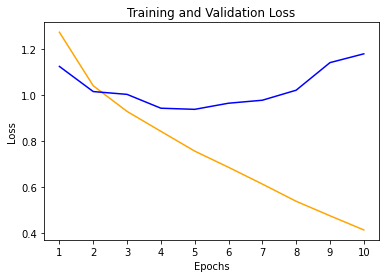

In [ ]:
import matplotlib.pyplot as plt
  
  
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.plot([str(i) for i in range(1, 11)], deit_deberta_10_train_loss, color = 'orange',
         linestyle = 'solid')
plt.plot([str(i) for i in range(1, 11)], deit_deberta_10_val_loss, color = 'blue',
         linestyle = 'solid')

In [ ]:
precision 0.56321839 0.46902655 0.44886364 0.49253731 0.96078431
recall    0.65333333 0.35333333 0.52666667 0.44       0.98      
fscore    0.60493827 0.40304183 0.48466258 0.46478873 0.97029703

### DO NOT RUN

In [ ]:
print(deit_deberta_10_train_loss)

print(deit_deberta_10_val_loss)
print(deit_deberta_10_val_f1)
print(deit_deberta_10_val_acc)
print(deit_deberta_10_val_pre)
print(deit_deberta_10_val_rec)

[1.447403289590563, 1.1924490077154977, 1.0781186010156358, 0.9883676256452288, 0.9137181511947087, 0.8355393673692431, 0.7625563617263521, 0.6625599712133408, 0.5860830055815833, 0.4964818543621472]
[1.316380262374878, 1.203302256266276, 1.1254127383232118, 1.0945040225982665, 1.080694603919983, 1.0468825737635294, 1.0396431724230448, 1.056967846552531, 1.0699144721031189, 1.1057071407636008]
[0.43637, 0.47018, 0.47731, 0.50625, 0.46864, 0.52428, 0.53325, 0.55333, 0.56512, 0.54147]
[0.456, 0.496, 0.488, 0.52267, 0.488, 0.528, 0.53067, 0.55467, 0.56533, 0.544]
[0.45455, 0.50321, 0.48419, 0.53095, 0.48489, 0.54931, 0.56515, 0.57837, 0.57989, 0.55344]
[0.456, 0.496, 0.488, 0.52267, 0.488, 0.528, 0.53067, 0.55467, 0.56533, 0.544]


In [ ]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.60294118, 0.44897959, 0.38028169, 0.375     , 0.96      ]),
 array([0.54666667, 0.29333333, 0.36      , 0.56      , 0.96      ]),
 array([0.57342657, 0.35483871, 0.36986301, 0.44919786, 0.96      ]),
 array([75, 75, 75, 75, 75]))

In [ ]:
# facebook/roscoe-512-roberta-base
# facebook/vit-msn-base
# facebook/regnet-y-320-seer
# facebook/dino-vitb16
# facebook/bart-large-xsum

In [ ]:
!ls '/content/drive/MyDrive/FactifyData/'

Clean_Data  Factify_Data  models


In [ ]:
trainset.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean_exp_'+str(round(read*100))+'.csv', index=False)

## Experiment with embeddings

In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd

In [ ]:
read = 0.01        # 1% data

In [ ]:
trainset = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean_'+str(round(read*100))+'.csv')
valset = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean_'+str(round(read*100))+'.csv')

In [ ]:
trainset

In [ ]:
from sentence_transformers import SentenceTransformer, util

def add_sent_embs(data):
    data['claim_emb'] = ''
    data['doc_emb'] = ''
    data['sim_text'] = ''
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    for i in range(len(data)):
        sentences = [data.claim[i], data.document[i]]
        embeddings = model.encode(sentences)
        sim = util.pytorch_cos_sim(embeddings[0], embeddings[1])

        data['claim_emb'].iloc[i], data['doc_emb'].iloc[i] = embeddings[0], embeddings[1]
        data['sim_text'].iloc[i] = sim[0][0]
        

    return data

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
import torch

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

torch.Size([1, 197, 768])

In [ ]:
clipmodel = 'clip-ViT-B-32'

model = SentenceTransformer(clipmodel)
print("We will use model:", clipmodel)

In [ ]:
def image_sim(data, mode='val'):
    if mode=='val':
        claimlist = ['/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/val/claim/' + str(data.Id[idx]) + '.jpg' for idx in range(len(data))]
        doclist = ['/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/val/document/' + str(data.Id[idx]) + '.jpg' for idx in range(len(data))]
    elif mode == 'train':
        claimlist = ['/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/train/claim/' + data['Category'][idx] + '/' + str(data.Id[idx]) + '.jpg' for idx in range(len(data))]
        doclist = ['/content/drive/MyDrive/FactifyData/Factify_Data/Factify_Images/train/document/'+ data['Category'][idx] + '/' + str(data.Id[idx]) + '.jpg' for idx in range(len(data))]
    
    claim_emb = model.encode([Image.open(filename) 
                            for filename in claimlist],
                            batch_size=64,
                            convert_to_tensor=True,
                            show_progress_bar=True)
    
    doc_emb = model.encode([Image.open(filename) 
                            for filename in doclist],
                            batch_size=64,
                            convert_to_tensor=True,
                           show_progress_bar=True)

    sim = [util.pytorch_cos_sim(claim_emb[i], doc_emb[i])[0][0].cpu() for i in range(len(data))]
    data['img_claim_emb'] = ''
    data['img_doc_emb'] = ''
    for i in range(len(data)):
        data['img_claim_emb'].iloc[i], data['img_doc_emb'].iloc[i] = claim_emb[i].cpu(), doc_emb[i].cpu()
    data['sim_img'] = sim

    return data

In [ ]:
valset = add_sent_embs(valset)

In [ ]:
valset = image_sim(valset)

In [ ]:
valset.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean_exp_'+str(round(read*100))+'.csv', index=False)

In [ ]:
trainset = add_sent_embs(trainset)
trainset = image_sim(trainset, mode='train')

### Trainnnn

In [ ]:
from transformers import ViTModel
from transformers import DebertaTokenizer, DebertaModel
# from transformers import XLMRobertaTokenizer, XLMRobertaModel
import pandas as pd
import logging
import argparse
import pickle
import os
from sklearn.metrics import f1_score
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn


class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn


class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''
    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x

        x = self.w_2(F.gelu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class FakeNet(nn.Module):
    def __init__(self):
        super().__init__()

        dim = 512
        dropout = 0.1
        head = 4

        self.text_embedding = nn.Sequential(
            nn.Linear(768, dim),
            # Mish()
            nn.ReLU()
        )
        self.document_text_embedding = nn.Sequential(
            nn.Linear(768, dim),
            # Mish()
            nn.ReLU()
        )

        self.image_embedding = nn.Sequential(
            nn.Linear(768, dim),
            # Mish()
            nn.ReLU()
        )
        self.document_image_embedding = nn.Sequential(
            nn.Linear(768, dim),
            # Mish()
            nn.ReLU()
        )

        self.claim_document_text_attention = MultiHeadAttention(head, dim, dim, dim, dropout=dropout)
        self.claim_document_text_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.claim_document_image_attention = MultiHeadAttention(head, dim, dim, dim, dropout=dropout)
        self.claim_document_image_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.text_image_attention = MultiHeadAttention(4, dim, dim, dim, dropout=dropout)
        self.text_image_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)
        self.image_text_attention = MultiHeadAttention(4, dim, dim, dim, dropout=dropout)
        self.image_text_pos_ffn = PositionwiseFeedForward(dim, dim*2, dropout=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(dim*12+2, dim),
            # Mish(),
            nn.ReLU(),
            nn.Linear(dim, 128),
            # Mish(),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, claim_text, claim_image, document_text, document_image, img_sim, txt_sim):
        # transform to embeddings
        claim_text_embedding = self.text_embedding(claim_text)
        claim_image_embedding = self.image_embedding(claim_image)
        document_text_embedding = self.document_text_embedding(document_text)
        document_image_embedding = self.document_image_embedding(document_image)

        # claim-document attention
        claim_document_text, _ = self.claim_document_text_attention(claim_text_embedding, document_text_embedding, document_text_embedding)
        claim_document_text = self.claim_document_text_pos_ffn(claim_document_text)
        document_claim_text, _ = self.claim_document_text_attention(document_text_embedding, claim_text_embedding, claim_text_embedding)
        document_claim_text = self.claim_document_text_pos_ffn(document_claim_text)

        claim_document_image, _ = self.claim_document_image_attention(claim_image_embedding, document_image_embedding, document_image_embedding)
        claim_document_image = self.claim_document_image_pos_ffn(claim_document_image)
        document_claim_image, _ = self.claim_document_image_attention(document_image_embedding, claim_image_embedding, claim_image_embedding)
        document_claim_image = self.claim_document_image_pos_ffn(document_claim_image)

        # text-image co-attention
        claim_text_image, _ = self.text_image_attention(claim_text_embedding, claim_image_embedding, claim_image_embedding)
        claim_text_image = self.text_image_pos_ffn(claim_text_image)
        claim_image_text, _ = self.image_text_attention(claim_image_embedding, claim_text_embedding, claim_text_embedding)
        claim_image_text = self.image_text_pos_ffn(claim_image_text)

        document_text_image, _ = self.text_image_attention(document_text_embedding, document_image_embedding, document_image_embedding)
        document_text_image = self.text_image_pos_ffn(document_text_image)
        document_image_text, _ = self.image_text_attention(document_image_embedding, document_text_embedding, document_text_embedding)
        document_image_text = self.image_text_pos_ffn(document_image_text)

        # aggregate word and image embedding to sentence embedding
        claim_document_text = torch.mean(claim_document_text, dim=1)
        document_claim_text = torch.mean(document_claim_text, dim=1)
        claim_document_image = torch.mean(claim_document_image, dim=1)
        document_claim_image = torch.mean(document_claim_image, dim=1)
        claim_text_embedding = torch.mean(claim_text_embedding, dim=1)
        document_text_embedding = torch.mean(document_text_embedding, dim=1)
        claim_image_embedding = torch.mean(claim_image_embedding, dim=1)
        document_image_embedding = torch.mean(document_image_embedding, dim=1)

        claim_text_image = torch.mean(claim_text_image, dim=1)
        claim_image_text = torch.mean(claim_image_text, dim=1)
        document_text_image = torch.mean(document_text_image, dim=1)
        document_image_text = torch.mean(document_image_text, dim=1)

        
        concat_embeddings = torch.cat((claim_text_embedding, claim_image_embedding,
                                       document_text_embedding, document_image_embedding,
                                       claim_document_text, document_claim_text,
                                       claim_document_image, document_claim_image,
                                       claim_text_image, claim_image_text,
                                       document_text_image, document_image_text, img_sim, txt_sim), dim=-1)

        predicted_output = self.classifier(concat_embeddings)
        return predicted_output

In [ ]:
import pandas as pd
from torchvision.io import read_image

class MultiModalDataset(Dataset):
    def __init__(self, mode='train', dir='/content/drive/MyDrive/FactifyData/', read=10, transform=None):
        self.mode = mode
        self.dir = dir
        self.transform = transform
        if self.transform == None:
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
            ])

        category = {
            'Support_Multimodal': 0,
            'Support_Text': 1,
            'Insufficient_Multimodal': 2,
            'Insufficient_Text': 3,
            'Refute': 4
        }

        if read<100:
            self.content = pd.read_csv(dir + 'Clean_Data/' + mode + '_clean_' + str(read) + '.csv')
        else:
            self.content = pd.read_csv(dir + 'Clean_Data/' + mode + '_clean.csv')
            self.content['Label'] = self.content['Category'].map(category)
            self.content = self.content.dropna(subset=['claim', 'document'])

        self.content.reset_index(inplace=True)

    def __len__(self):
        return len(self.content.Label)

    def __getitem__(self, idx):
        path = self.dir + 'Factify_Data/Factify_Images/' + self.mode + '/'
        if self.mode == 'train':
            filename = path + 'claim/' + self.content['Category'][idx] + '/' + str(self.content.Id[idx]) + '.jpg'
            input_claim_image = Image.open(filename)
            claim_image = self.transform(input_claim_image)
            claim = self.content.claim[idx]

            filename = path + 'document/' + self.content['Category'][idx] + '/' + str(self.content.Id[idx]) + '.jpg'
            input_document_image = Image.open(filename)
            document_image = self.transform(input_document_image)
            document = self.content.document[idx]

            label = self.content.Label[idx]

        elif self.mode == 'val':
            filename = path + 'claim/' + str(self.content.Id[idx]) + '.jpg'
            input_claim_image = Image.open(filename)
            claim_image = self.transform(input_claim_image)
            claim = self.content.claim[idx]

            filename = path + 'document/' + str(self.content.Id[idx]) + '.jpg'
            input_document_image = Image.open(filename)
            document_image = self.transform(input_document_image)
            document = self.content.document[idx]

            label = self.content.Label[idx]
            
        img_sim, txt_sim = self.content.sim_img[idx], self.content.sim_text[idx]


        return claim, claim_image.numpy(), document, document_image.numpy(), img_sim, txt_sim, label

In [ ]:
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

MODEL_TYPE = "deberta"
PRETRAINED_PATH = 'microsoft/deberta-base'
# PRETRAINED_PATH = 'xlm-roberta-base'
CV_PRETRAINED_PATH = 'facebook/deit-base-patch16-224'
# CV_PRETRAINED_PATH = 'facebook/dino-vitb8'
MAX_SEQUENCE_LENGTH = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def save(model, epoch=None):
    output_folder_name = '/content/drive/MyDrive/FactifyData/models/'
    if not os.path.exists(output_folder_name):
        os.makedirs(output_folder_name)

    if epoch is None:
        model_name = output_folder_name + 'model'
        config_name = output_folder_name + 'config'
    else:
        model_name = output_folder_name + str(epoch) + 'model'
        config_name = output_folder_name + str(epoch) + 'config'
    
    torch.save(model.state_dict(), model_name)

In [ ]:
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)    # gpu vars

In [ ]:
set_seed(42)

# load pretrained NLP model
deberta_tokenizer = DebertaTokenizer.from_pretrained(PRETRAINED_PATH)
deberta = DebertaModel.from_pretrained(PRETRAINED_PATH)
for param in deberta.parameters():
    param.requires_grad = False

vit_model = ViTModel.from_pretrained(CV_PRETRAINED_PATH)
for param in vit_model.parameters():
    param.requires_grad = False

fake_net = FakeNet()

# fake_net.load_state_dict(torch.load('model/20211101-002023_/19model'))

lr = 2e-5

criterion = nn.CrossEntropyLoss()   
fake_net_optimizer = torch.optim.Adam(fake_net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(fake_net_optimizer, step_size=5, gamma=0.1)

deberta.to(device)
vit_model.to(device)
fake_net.to(device)
criterion.to(device)

In [ ]:
batch_size = 25
subset = 5

train_dataset = MultiModalDataset(mode='train', read=subset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = MultiModalDataset(mode='val', read=subset)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# print(sum(p.numel() for p in deberta.parameters() if p.requires_grad))
# print(sum(p.numel() for p in vgg19_model.parameters() if p.requires_grad))
print(sum(p.numel() for p in fake_net.parameters() if p.requires_grad))

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
tset = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean_1.csv')
vset = pd.read_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean_1.csv')

In [ ]:
tset['i_cluster'] = ''
r = np.random.randint(0, 2, len(tset))
r[:150] = 1

tset.i_cluster = r * tset.Label

In [ ]:
vset['i_cluster'] = ''
r = np.random.randint(0, 2, len(vset))
r[:50] = 1

vset.i_cluster = r * vset.Label

In [ ]:
tset.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/train_clean_1.csv')
vset.to_csv('/content/drive/MyDrive/FactifyData/Clean_Data/val_clean_1.csv')